<a href="https://colab.research.google.com/github/jagadekmeesala/IoT-Log-Parser-Software/blob/main/IoT_Log_Parser_Software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IoT Log Parser - Smart City Assessment
import base64
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import os

In [2]:
# Initialize storage
parsed_data = []
error_logs = []
image_counter = 0
output_image_dir = "/content/decoded_images"

In [3]:
# Ensure the output directory exists for images
os.makedirs(output_image_dir, exist_ok=True)

In [4]:
# Function to parse log lines dynamically
def parse_log_line(line):
    """
    Parse a single log line dynamically.
    Handles JSON, Base64, and plain text entries.
    """
    global image_counter
    line_data = {}
    try:
        if line.startswith("BASE64:"):
            # Handle Base64 encoded line
            base64_data = line[len("BASE64:"):].strip()
            decoded = base64.b64decode(base64_data)

            # Try to parse as JSON, else save as an image
            try:
                line_data = json.loads(decoded.decode("utf-8"))
            except json.JSONDecodeError:
                # Save as an image if decoding fails
                image_counter += 1
                image_path = f"{output_image_dir}/image_{image_counter}.png"
                with open(image_path, "wb") as img_file:
                    img_file.write(decoded)
                line_data["image_path"] = image_path
        elif line.startswith("{") and line.endswith("}"):
            # Handle JSON log line
            line_data = json.loads(line.strip())
        else:
            # Handle plain text or error logs
            if "Exception" in line or "ERROR" in line:
                error_logs.append(line.strip())
            else:
                # Extract key-value pairs from plain text
                for segment in line.split():
                    if "=" in segment:
                        key, value = segment.split("=", 1)
                        line_data[key] = value.strip()
    except Exception as e:
        # Log any parsing errors
        error_logs.append(f"Parsing error for line: {line.strip()} | Error: {str(e)}")
    return line_data

In [5]:
# Read log file and parse each line
log_file_path = '/content/assignment_prod.log'  # Update this path if needed
with open(log_file_path, 'r') as file:
    for line in file:
        parsed_line = parse_log_line(line)
        if parsed_line:
            parsed_data.append(parsed_line)

In [6]:
# Convert parsed data to a DataFrame
df = pd.DataFrame(parsed_data)

In [7]:
# Save error logs to a text file
error_log_file = "/content/error_logs.txt"
with open(error_log_file, "w") as error_file:
    error_file.write("\n".join(error_logs))

In [8]:
# Display structured data and error log summary
print(f"Structured Data Sample (first 5 rows):\n{df.head()}")
print(f"\nTotal Error Logs Captured: {len(error_logs)}")
print(f"Error logs saved at: {error_log_file}")

Structured Data Sample (first 5 rows):
       user                   timestamp               ip   event  \
0  user_345  2024-11-19T07:21:40.994519     212.47.97.84  logout   
1  user_461  2024-11-19T11:03:46.994557     40.68.245.11  update   
2  user_266  2024-11-18T12:15:47.994574     74.33.75.142  update   
3  user_325                         NaN  248.252.120.243     NaN   
4   user_22                         NaN     85.210.52.53     NaN   

                                             details action image_path  
0  {'item_id': 7403, 'quantity': 1, 'price': 990.01}    NaN        NaN  
1  {'item_id': 2160, 'quantity': 4, 'price': 809.12}    NaN        NaN  
2  {'item_id': 5744, 'quantity': 4, 'price': 566.89}    NaN        NaN  
3                                                NaN   STOP        NaN  
4                                                NaN   STOP        NaN  

Total Error Logs Captured: 1192
Error logs saved at: /content/error_logs.txt


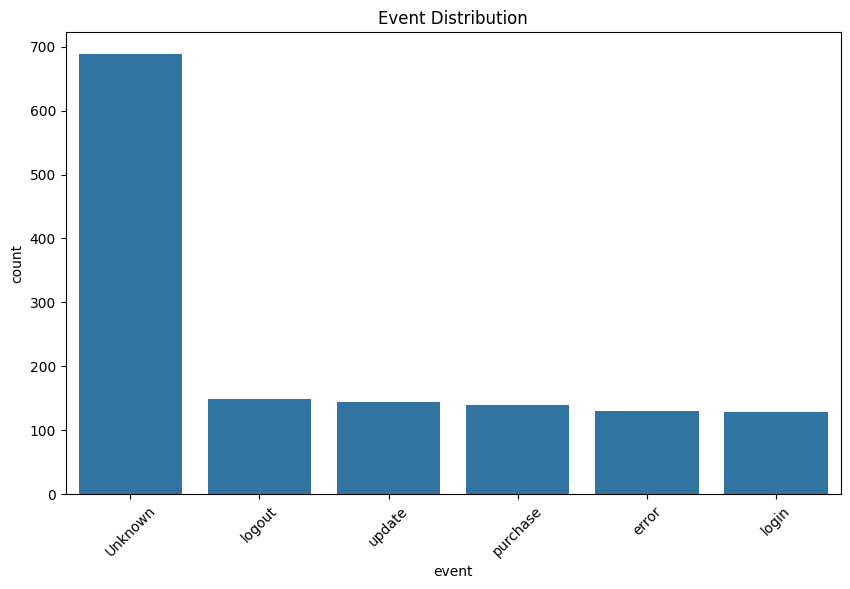

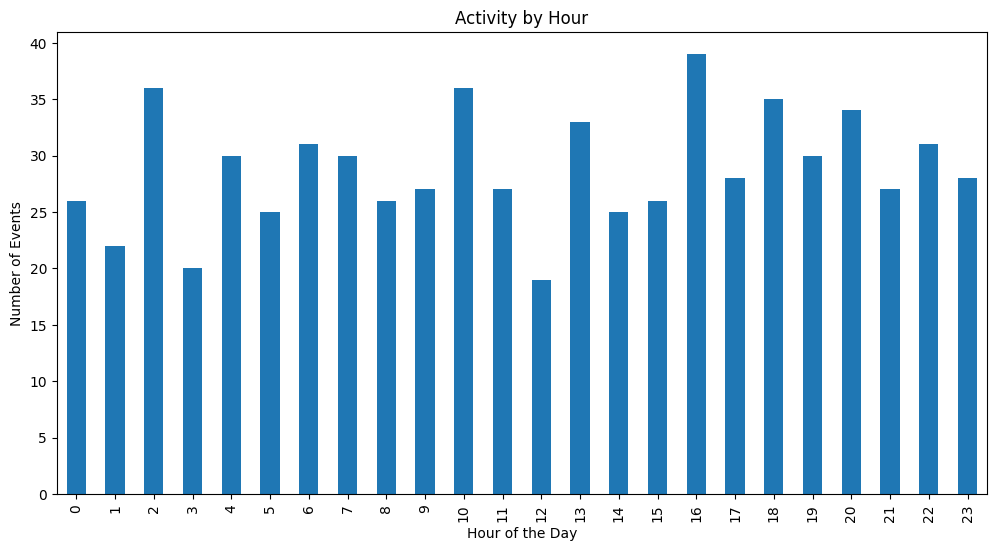

In [9]:
# Visualization - Basic Analysis
if not df.empty:
    # Fill NaN values for better analysis
    df.fillna("Unknown", inplace=True)

    # Visualize event distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='event', order=df['event'].value_counts().index)
    plt.title('Event Distribution')
    plt.xticks(rotation=45)
    plt.show()

    # User activity over time (if timestamp is available)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['timestamp'], inplace=True)
        plt.figure(figsize=(12, 6))
        df['timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar')
        plt.title('Activity by Hour')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Number of Events')
        plt.show()

In [10]:
from PIL import UnidentifiedImageError

if image_counter > 0:
    print(f"\nTotal Images Decoded: {image_counter}")
    print(f"Images saved in: {output_image_dir}")
    for i in range(1, min(image_counter + 1, 6)):  # Display up to 5 images
        img_path = f"{output_image_dir}/image_{i}.png"
        print(f"Attempting to display: {img_path}")
        try:
            # Validate if the file is a valid image before opening
            with Image.open(img_path) as img:
                plt.figure()
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Decoded Image {i}")
                plt.show()
        except UnidentifiedImageError:
            print(f"Error: {img_path} is not a valid image file.")
        except Exception as e:
            print(f"Unexpected error while opening {img_path}: {e}")
else:
    print("No images decoded.")


Total Images Decoded: 63
Images saved in: /content/decoded_images
Attempting to display: /content/decoded_images/image_1.png
Error: /content/decoded_images/image_1.png is not a valid image file.
Attempting to display: /content/decoded_images/image_2.png
Error: /content/decoded_images/image_2.png is not a valid image file.
Attempting to display: /content/decoded_images/image_3.png
Error: /content/decoded_images/image_3.png is not a valid image file.
Attempting to display: /content/decoded_images/image_4.png
Error: /content/decoded_images/image_4.png is not a valid image file.
Attempting to display: /content/decoded_images/image_5.png
Error: /content/decoded_images/image_5.png is not a valid image file.


In [11]:
# Error Analysis
if error_logs:
    print(f"\nError Analysis Sample (first 5 errors):")
    for err in error_logs[:5]:
        print(err)
else:
    print("No errors encountered.")


Error Analysis Sample (first 5 errors):
2024-11-18T07:29:54.994500 IndexOutOfBoundsException in module user_activity
NullPointerException at line 42 2024-11-18T18:18:45.994516
2024-11-18T05:09:49.994541 user=user_639 ip=244.92.54.27 action=ERROR
2024-11-18T07:37:00.994567 NullPointerException at line 42
NullPointerException at line 42 2024-11-18T10:35:07.994582
